In [3]:
import copy
import sys
import urllib
import pathlib

import sunpy.map
import eispac.core
from sunpy.coordinates import propagate_with_solar_surface
import astropy.wcs
import astropy.units as u
import astropy.io.fits
from astropy.coordinates import SkyCoord
import numpy as np
import matplotlib.pyplot as plt
from sunpy.net import Fido, attrs as a
from xrtpy.response import xrt_teem, TemperatureResponseFundamental

sys.path.append('../pipeline/')
from net.heliocloud import HelioCloudClient
import net.attrs as heliocloud_attrs
from correct_eis_pointing import shift_pointing, cross_correlate_with_aia

In [4]:
file_urls = [
    'http://solar.physics.montana.edu/HINODE/XRT/SCIA/synop_official/2012/09/24/H1000/comp_XRT20120924_100307.8.fits',
    'http://solar.physics.montana.edu/HINODE/XRT/SCIA/synop_official/2012/09/24/H1000/comp_XRT20120924_100346.8.fits',
    'http://solar.physics.montana.edu/HINODE/XRT/SCIA/synop_official/2012/09/24/H1000/comp_XRT20120924_100424.3.fits',
]

In [5]:
xrt_maps = sunpy.map.Map(file_urls)

In [6]:
m_eis = sunpy.map.Map('../pipeline/data/EIS/level_2.5/eis_20120924_105026.fe_12_195_119.2c-0.int.fits')

In [12]:
query = Fido.search(
    a.Time(xrt_maps[0].date-2*u.min, xrt_maps[0].date+2*u.min),
    a.Wavelength(94*u.angstrom),
    heliocloud_attrs.Dataset('AIA'),
)

In [13]:
with astropy.io.fits.open(query[0]['URL'][0], use_fsspec=True, fsspec_kwargs={'anon': True}) as hdul:
    data = hdul[1].data
    header = hdul[1].header
    m_94 = sunpy.map.Map(data, header)

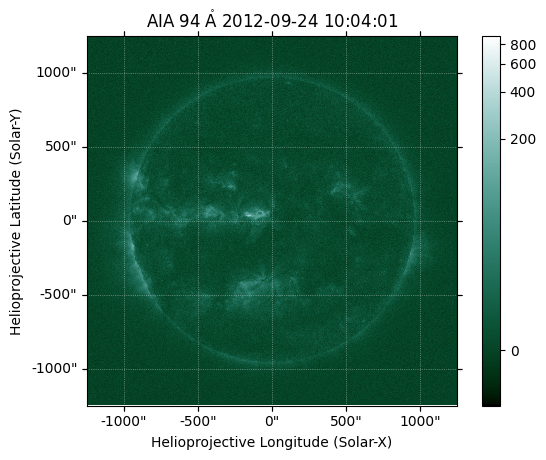

In [14]:
m_94.peek()

There is a clear pointing offset between the XRT and EIS emission

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crlt_obs,crln_obs
For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,solar_b0
 [sunpy.map.mapbase]


(-0.5, 511.5)

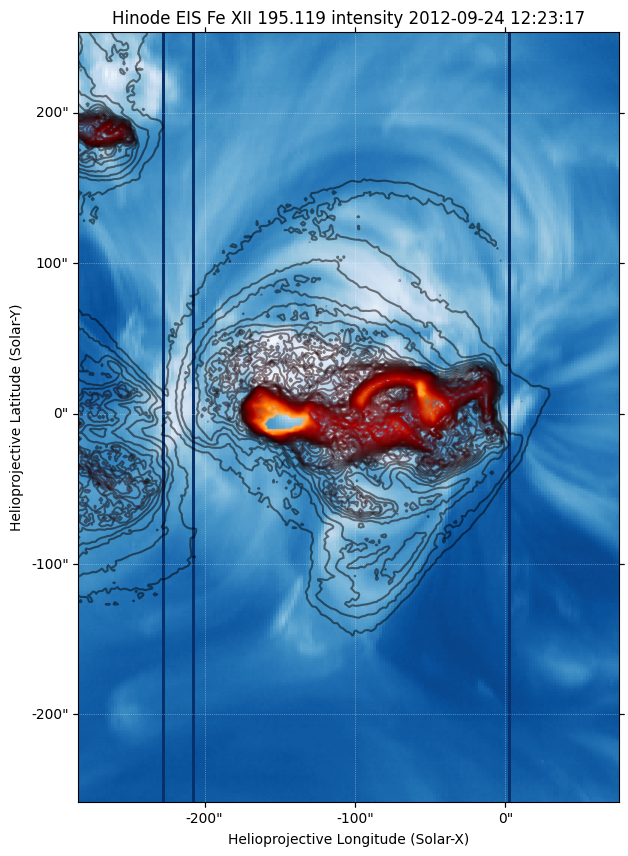

In [15]:
fig = plt.figure(figsize=(7,10))
ax = fig.add_subplot(projection=m_eis)
m_eis.plot(axes=ax)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
with propagate_with_solar_surface():
    xrt_maps[0].draw_contours(np.arange(1,100,1)*u.percent, axes=ax, cmap='hinodexrt', alpha=.5,)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

This can also be seen in comparison to an AIA image taken at the same time as the XRT image

(1984.7921851682772, 3006.75352382089)

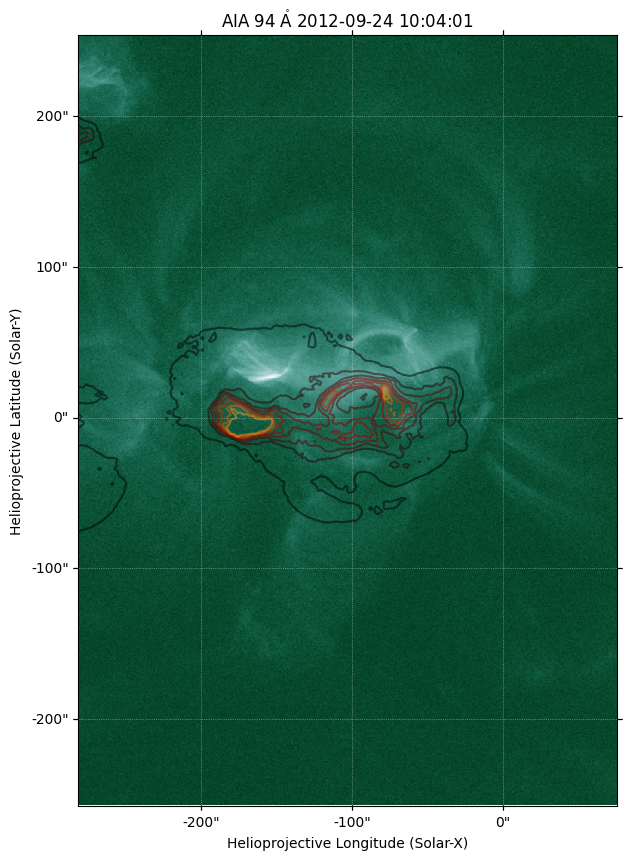

In [16]:
fig = plt.figure(figsize=(7,10))
ax = fig.add_subplot(projection=m_94)
m_94.plot(axes=ax)
xrt_maps[0].draw_contours(np.arange(5,100,10)*u.percent, axes=ax, cmap='hinodexrt', alpha=0.5)
blc_pix = m_94.wcs.world_to_pixel(m_eis.bottom_left_coord)
trc_pix = m_94.wcs.world_to_pixel(m_eis.top_right_coord)
ax.set_xlim(blc_pix[0], trc_pix[0])
ax.set_ylim(blc_pix[1], trc_pix[1])

First, work out the pointing correction for XRT by applying a cross-correlation analysis with AIA 94

In [17]:
pad = 200 * u.arcsec
blc = SkyCoord(Tx=m_eis.bottom_left_coord.Tx-pad,
               Ty=m_eis.bottom_left_coord.Ty-pad,
               frame=m_eis.coordinate_frame)
trc = SkyCoord(Tx=m_eis.top_right_coord.Tx+pad,
               Ty=m_eis.top_right_coord.Ty+pad,
               frame=m_eis.coordinate_frame)

In [19]:
with propagate_with_solar_surface():
    xrt_submaps = [m.rotate().submap(blc, top_right=trc) for m in xrt_maps]
ref_coord = cross_correlate_with_aia(xrt_submaps[0], m_94.resample(u.Quantity(xrt_maps[0].dimensions)))
xrt_maps_corrected = sunpy.map.Map([shift_pointing(m, ref_coord) for m in xrt_submaps])

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crlt_obs,crln_obs
For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,solar_b0
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crlt_obs,crln_obs
For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,solar_b0
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crlt_obs,crln_obs
For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,solar_b0
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crlt_obs,crln_obs
For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,solar_b0
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crlt_obs,crln_obs
For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,solar_b0
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crlt_obs,crln_obs
For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,solar_b0
 [sunpy.map.mapbase]


Now, we can see that there is a much closer correspondence between the emission from these two instruments.

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crlt_obs,crln_obs
For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,solar_b0
 [sunpy.map.mapbase]


(1984.7921851682772, 3006.75352382089)

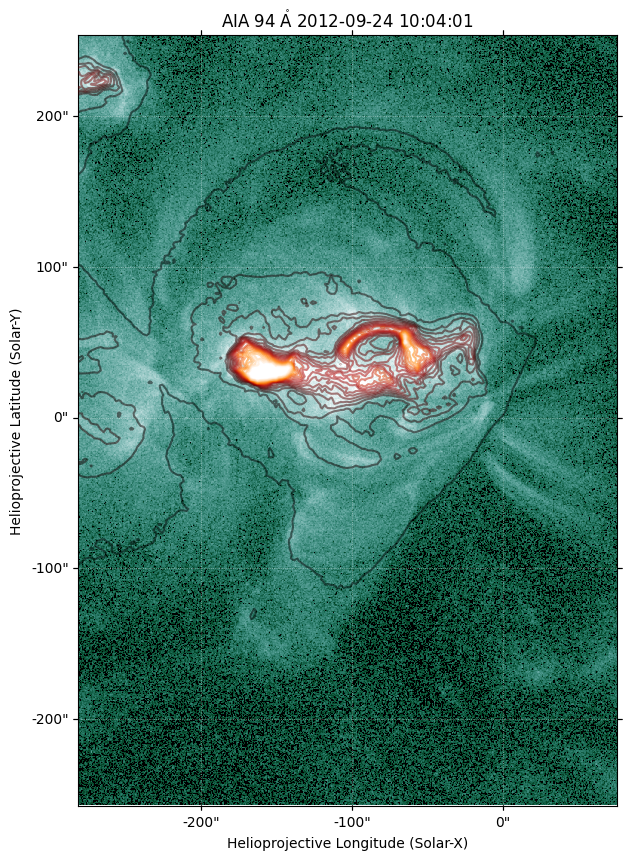

In [20]:
fig = plt.figure(figsize=(7,10))
ax = fig.add_subplot(projection=m_94)
m_94.plot(axes=ax, vmin=0, vmax=100)
xrt_maps_corrected[0].draw_contours(np.arange(1,100,5)*u.percent,
                                    axes=ax, cmap='hinodexrt', alpha=0.5)
blc_pix = m_94.wcs.world_to_pixel(m_eis.bottom_left_coord)
trc_pix = m_94.wcs.world_to_pixel(m_eis.top_right_coord)
ax.set_xlim(blc_pix[0], trc_pix[0])
ax.set_ylim(blc_pix[1], trc_pix[1])

Then, reproject each XRT map to a WCS aligned with the EIS FOV

In [21]:
def get_new_header(ref_map, source_map):
    extent = u.Quantity(ref_map.dimensions) * u.Quantity(ref_map.scale)
    shape = tuple(np.ceil(extent / u.Quantity(source_map.scale)).to_value('pix').astype(int)[::-1])
    ref_header = sunpy.map.make_fitswcs_header(shape,
                                               ref_map.center,
                                               scale=u.Quantity(source_map.scale),
                                               rotation_matrix=ref_map.rotation_matrix,
                                               wavelength=source_map.wavelength,
                                               instrument=source_map.instrument,
                                               telescope=source_map.meta['telescop'],
                                               observatory=source_map.observatory,
                                               detector=source_map.detector)
    return ref_header

In [22]:
ref_header = get_new_header(m_eis, xrt_maps_corrected[0])
ref_wcs = astropy.wcs.WCS(header=ref_header)

In [23]:
with propagate_with_solar_surface():
    xrt_maps_reprojected = []
    for m in xrt_maps_corrected:
        m_reprojected = m.reproject_to(ref_wcs, algorithm='adaptive')
        new_header = copy.deepcopy(ref_header)
        new_header['ec_fw1_'] = m.meta['ec_fw1_']
        new_header['ec_fw2_'] = m.meta['ec_fw2_']
        m_reprojected = sunpy.map.Map(m_reprojected.data, new_header)
        xrt_maps_reprojected.append(m_reprojected)
xrt_maps_reprojected = sunpy.map.Map(xrt_maps_reprojected)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crlt_obs,crln_obs
For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,solar_b0
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crlt_obs,crln_obs
For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,solar_b0
 [sunpy.map.mapbase]


Finally, we can lay the XRT contours on top of our original EIS image to ensure that the two match up (in terms of morphology)

(-0.5, 511.5)

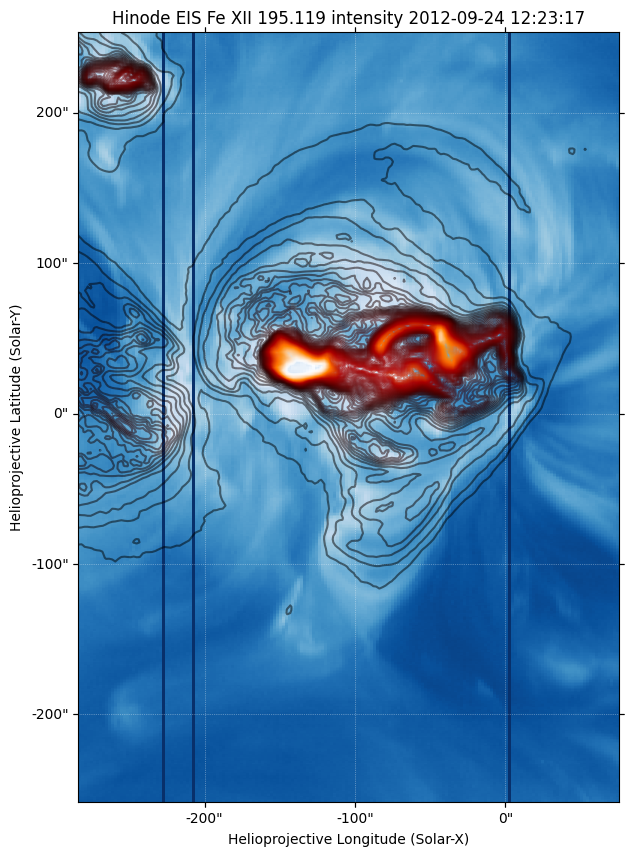

In [24]:
fig = plt.figure(figsize=(7,10))
ax = fig.add_subplot(projection=m_eis)
m_eis.plot(axes=ax)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xrt_maps_reprojected[0].draw_contours(np.arange(1,100,1)*u.percent, axes=ax, cmap='hinodexrt', alpha=.5,)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

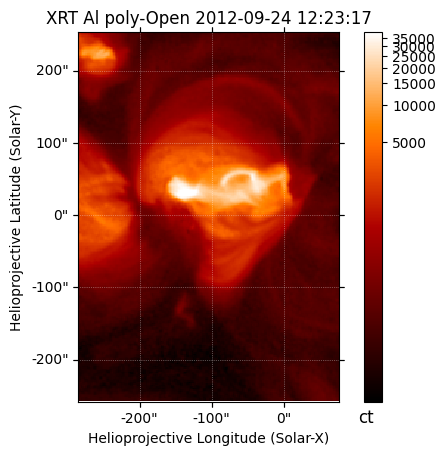

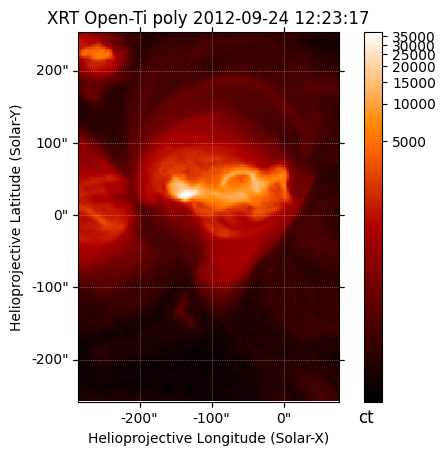

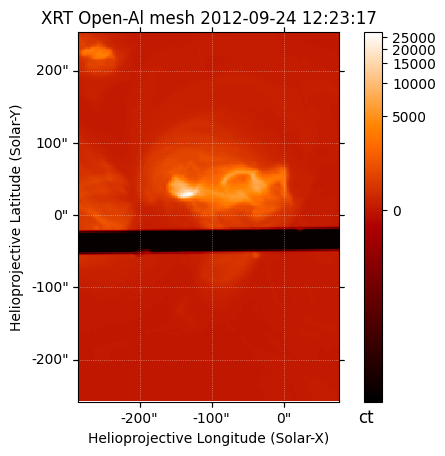

In [25]:
for m in xrt_maps_reprojected:
    m.peek()

In [26]:
new_scale = [0.6,0.6] * u.arcsec / u.pix
print(u.Quantity(m_eis.scale)*u.Quantity(m_eis.dimensions) / new_scale)
print(u.Quantity(xrt_maps_reprojected[0].scale)*u.Quantity(xrt_maps_reprojected[0].dimensions) / new_scale)

[599.04       853.33333333] pix
[602.3074     854.11953333] pix


(1e-27, 1e-24)

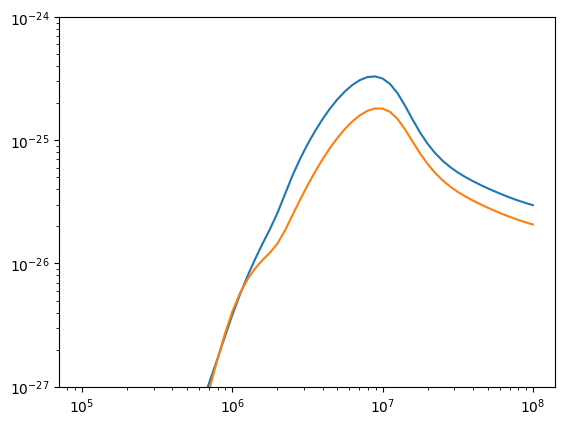

In [21]:
tf_al = TemperatureResponseFundamental('Al-poly', xrt_maps_reprojected[0].date,)
tf_ti = TemperatureResponseFundamental('Ti-poly', xrt_maps_reprojected[0].date,)
plt.plot(tf_al.CHIANTI_temperature, tf_al.temperature_response())
plt.plot(tf_ti.CHIANTI_temperature, tf_ti.temperature_response())
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-27, 1e-24)

In [22]:
tr_maps = xrt_teem.xrt_teem(xrt_maps_reprojected[0], xrt_maps_reprojected[1], Trange=[6,7],)

KeyError: 'history'

In [52]:
m_eis.nickname

'Hinode EIS Fe XII 195.119'

In [55]:
xrt_maps_reprojected[0].instrument

'XRT'

In [56]:
m_eis.measurement

'intensity'

In [58]:
if line_id := xrt_maps_reprojected[0].meta.get('line_id', None):
    print(line_id)

In [61]:
xrt_maps_reprojected[0].measurement

'Al poly-Open'

In [62]:
m_eis.instrument

'EIS'

In [63]:
xrt_maps_reprojected[0].instrument

'XRT'

In [64]:
import xarray

In [73]:
xrt_ds = xarray.open_dataset('../pipeline/data/XRT/loop_cutouts.nc')

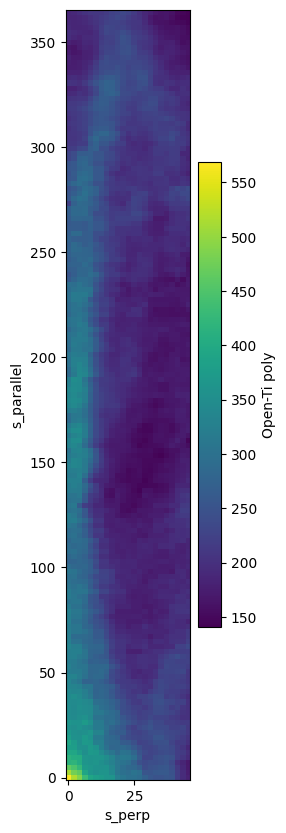

In [74]:
xrt_ds['Open-Ti poly'].plot.imshow(aspect=0.2, size=10)

In [75]:
m_xrt = sunpy.map.Map('../pipeline/data/XRT/level_2.5/comp_XRT20120924_100307.8.fits')

In [79]:
import asdf
with asdf.open('../pipeline/static/traced-loop.asdf') as af:
    loop = af.tree['loop']

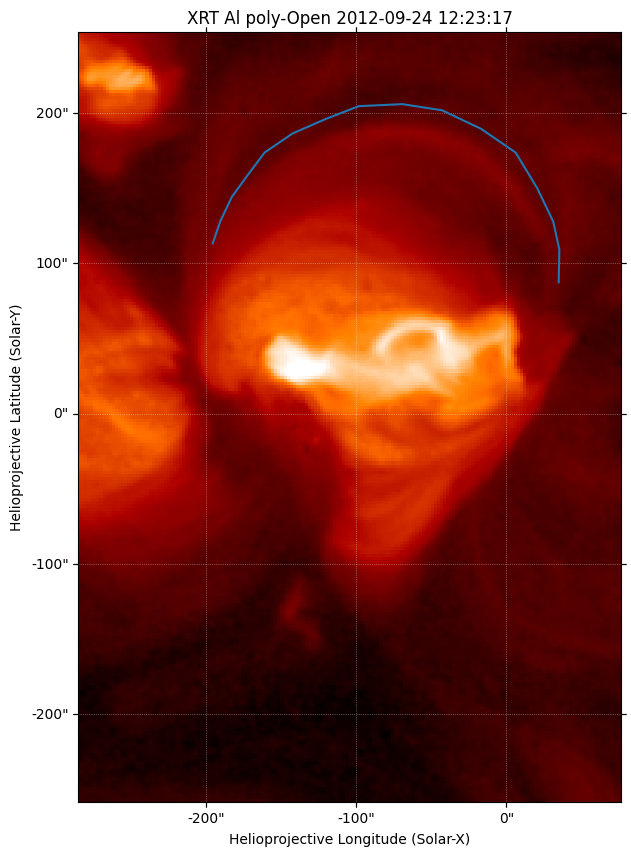

In [80]:
fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(projection=m_xrt)
m_xrt.plot(axes=ax)
ax.plot_coord(loop)

In [27]:
import zarr

In [28]:
root = zarr.open('../pipeline/data/AIA/level_2/', mode='r')

In [35]:
astropy.wcs.WCS(header=root['94'].attrs['meta'])

WCS Keywords

Number of WCS axes: 2
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  
CRVAL : -0.028934056400580124  -0.0005537163055191636  
CRPIX : 300.5  427.5  
PC1_1 PC1_2  : 1.0  -0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00016666666666666666  0.00016666666666666666  
NAXIS : 600  854

In [33]:
astropy.wcs.WCS(root['94'].attrs['wcs'])

WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'TIME'  
CRVAL : -0.02893405640058  -0.00055371630551916  0.0  
CRPIX : 300.5  427.5  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 0.00016666666666667  0.00016666666666667  240.0  
NAXIS : 0  0

In [36]:
m = sunpy.map.Map('../pipeline/data/EIS/level_2.5/eis_20120924_105026.al_09_284_015.2c-0.wid.fits')

In [38]:
m.meta['line_id']

'Al IX 284.015'

In [41]:
xrt_maps_reprojected[0].meta

MetaDict([('wcsaxes', 2),
          ('crpix1', 89.0),
          ('crpix2', 126.0),
          ('cdelt1', 2.04172),
          ('cdelt2', 2.04172),
          ('cunit1', 'arcsec'),
          ('cunit2', 'arcsec'),
          ('ctype1', 'HPLN-TAN'),
          ('ctype2', 'HPLT-TAN'),
          ('crval1', -104.16260304208845),
          ('crval2', -1.9933786998689889),
          ('lonpole', 180.0),
          ('latpole', 0.0),
          ('mjdref', 0.0),
          ('date-obs', '2012-09-24T12:23:17.500'),
          ('rsun_ref', 695700000.0),
          ('dsun_obs', 150047074575.43),
          ('hgln_obs', -1.1368683772162e-13),
          ('hglt_obs', 6.974213258604),
          ('instrume', 'XRT'),
          ('telescop', 'HINODE'),
          ('obsrvtry', 'Hinode'),
          ('detector', 'XRT'),
          ('naxis', 2),
          ('naxis1', 177),
          ('naxis2', 251),
          ('pc1_1', 1.0),
          ('pc1_2', -0.0),
          ('pc2_1', 0.0),
          ('pc2_2', 1.0),
          ('rsun_obs', 9

In [39]:
m_eis.meta

MetaDict([('simple', True),
          ('bitpix', -64),
          ('naxis', 2),
          ('naxis1', 180),
          ('naxis2', 512),
          ('date_obs', '2012-09-24T10:50:26.000'),
          ('date_beg', '2012-09-24T10:50:26.000'),
          ('date_avg', '2012-09-24T12:23:17.500'),
          ('date_end', '2012-09-24T13:56:09.000'),
          ('timesys', 'UTC'),
          ('telescop', 'Hinode'),
          ('instrume', 'EIS'),
          ('stud_acr', 'HPW021_VEL_360x512v1'),
          ('obstitle',
           'Large FOV scan after long sequence of fast scans.                  &'),
          ('target', 'Active Region'),
          ('sci_obj',
           'AR                                                                 &'),
          ('line_id', 'Fe XII 195.119'),
          ('measrmnt', 'intensity'),
          ('bunit', 'erg / (s sr cm2)'),
          ('slit_id', '1"'),
          ('slit_ind', 0),
          ('nraster', 180),
          ('cname1', 'Solar-X'),
          ('crval1', -282.876021

In [42]:
m_eis.measurement

'intensity'

In [43]:
import distributed

In [44]:
client = distributed.Client()

In [45]:
client.scheduler.address

'tcp://127.0.0.1:45915'

In [49]:
zarr.open(pathlib.Path('../pipeline/data/AIA/level_2/171').parent, mode='r')

<zarr.hierarchy.Group '/' read-only>

In [50]:
import re

In [69]:
foo = re.compile(r'\b(XRT|EIS)\b', re.I)

In [72]:
foo.findall('AIA')

[]